In [1]:
from __future__ import division, print_function
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.color import rgb2gray
from skdemo import imshow_all

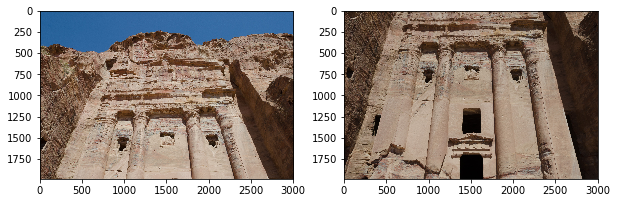

In [9]:
ic = io.ImageCollection('pano-image/DFM_*')
imshow_all(ic[0], ic[1])

In [10]:
image0 = rgb2gray(ic[0][:, 500:500+1987, :])
image1 = rgb2gray(ic[1][:, 500:500+1987, :])

image0 = transform.rescale(image0, 0.25)
image1 = transform.rescale(image1, 0.25)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


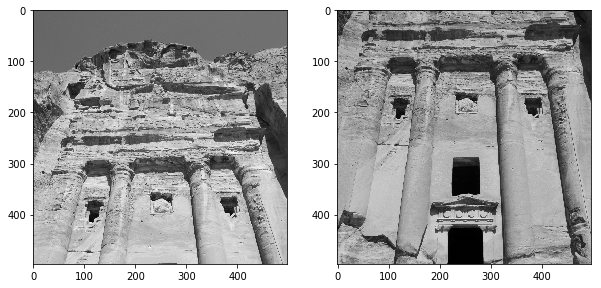

In [11]:
imshow_all(image0, image1)

In [12]:
from skimage.feature import ORB, match_descriptors

orb = ORB(n_keypoints=1000, fast_threshold=0.05)

orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

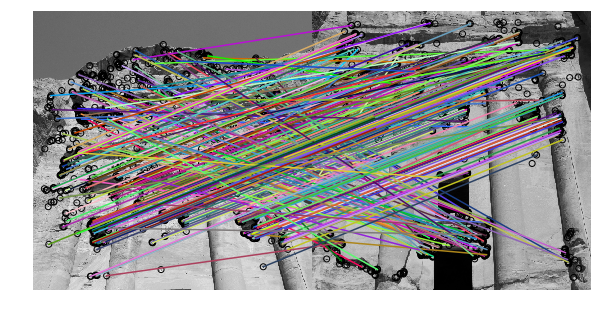

In [13]:
from skimage.feature import plot_matches

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
ax.axis('off');

In [14]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

# Select keypoints from the source (image to be registered)
# and target (reference image)
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                               min_samples=4, residual_threshold=2)

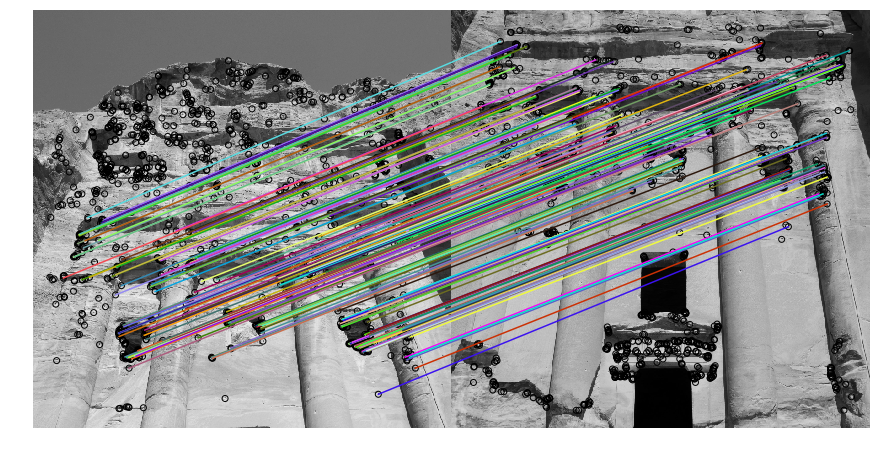

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12[inliers])
ax.axis('off');

In [16]:
from skimage.transform import SimilarityTransform

r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners = model_robust(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

In [17]:
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

In [18]:
def add_alpha(image, background=-1):
    """Add an alpha layer to the image.
    
    The alpha layer is set to 1 for foreground and 0 for background.
    """
    return np.dstack((gray2rgb(image), (image != background)))

image0_alpha = add_alpha(image0_)
image1_alpha = add_alpha(image1_)

merged = (image0_alpha + image1_alpha)
alpha = merged[..., 3]

# The summed alpha layers give us an indication of how many
# images were combined to make up each pixel.  Divide by the
# number of images to get an average.
merged /= np.maximum(alpha, 1)[..., np.newaxis]
merged = merged[..., :3]

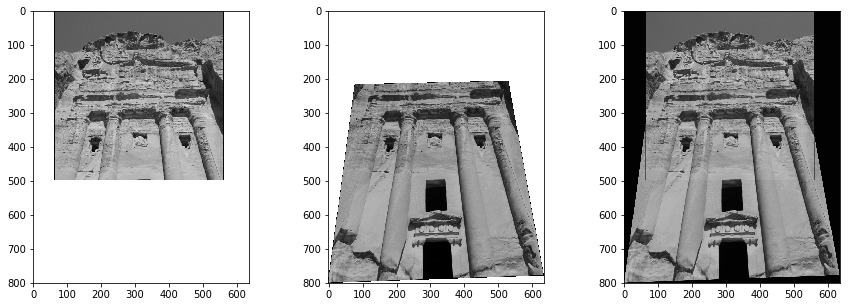

In [19]:
imshow_all(image0_alpha, image1_alpha, merged)

In [22]:
plt.imsave('temp-image/frame0.tif', image0_alpha)
plt.imsave('temp-image/frame1.tif', image1_alpha)

In [28]:
%%bash
#sudo apt install enblend

enblend temp-image/frame*.tif -o temp-image/pano.tif

enblend: warning: no usable resolution found in first image "temp-image/frame0.tif";
enblend: warning:   will use 300 dpi
enblend: info: loading next image: temp-image/frame0.tif 1/1
enblend: info: loading next image: temp-image/frame1.tif 1/1
enblend: info: writing final output


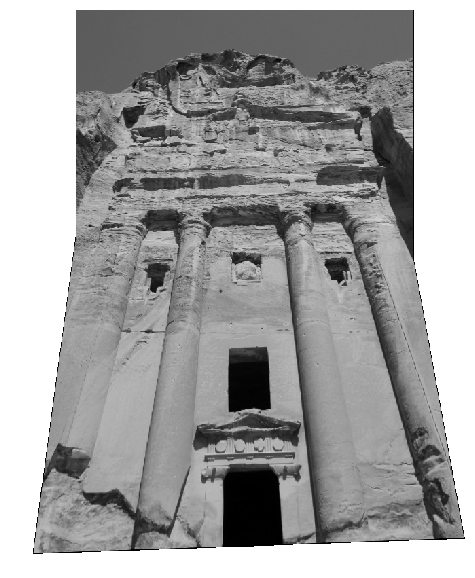

In [32]:
pano = io.imread('temp-image/pano.tif')

plt.figure(figsize=(10, 10))
plt.imshow(pano)
plt.axis('off');

